# Real-time IIoT Data Demo Notebook

In [1]:
import boto3
import pandas as pd
from datetime import datetime
from numpy import isnan
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

In [2]:
def parse(x):
    x = pd.to_numeric(x, downcast='float')
    return pd.Timestamp(x, unit='s')

In [3]:
client = boto3.client('iotanalytics')
dataset = "iot_data_dataset_container"
data_location = client.get_dataset_content(datasetName = dataset)['entries'][0]['dataURI']
df = pd.read_csv(data_location,
                      header=0, 
                      low_memory=False, 
                      infer_datetime_format=True, 
                      date_parser=parse,
                      index_col=['ts'])

In [4]:
print(df.head(5))

                                 device   humidity       temp  light  motion  \
ts                                                                             
2020-07-01 00:04:16  iot-demo-device-02  71.099998  64.039999   True   False   
2020-07-01 00:04:16  iot-demo-device-01  73.400002  66.019999  False   False   
2020-07-01 00:04:16  iot-demo-device-02  71.000000  64.039999   True   False   
2020-07-01 00:04:16  iot-demo-device-01  73.400002  66.019999  False   False   
2020-07-01 00:04:16  iot-demo-device-02  71.000000  64.039999   True   False   

                          lpg        co     smoke                     __dt  
ts                                                                          
2020-07-01 00:04:16  0.008060  0.005326  0.021579  2020-07-01 00:00:00.000  
2020-07-01 00:04:16  0.020303  0.019101  0.057893  2020-07-01 00:00:00.000  
2020-07-01 00:04:16  0.008060  0.005326  0.021579  2020-07-01 00:00:00.000  
2020-07-01 00:04:16  0.020303  0.019101  0.057893  202

In [5]:
print(df.count())

device      490002
humidity    490002
temp        490002
light       490002
motion      490002
lpg         490002
co          490002
smoke       490002
__dt        490002
dtype: int64


In [11]:
df_filtered = df.sort_values(ascending=False, by='ts').head(5000)

q_low = df_filtered["humidity"].quantile(0.01)
q_hi  = df_filtered["humidity"].quantile(0.99)

df_filtered = df_filtered[(df_filtered["humidity"] < q_hi) & (df_filtered["humidity"] > q_low)]

q_low = df_filtered["temp"].quantile(0.01)
q_hi  = df_filtered["temp"].quantile(0.99)

df_filtered = df_filtered[(df_filtered["temp"] < q_hi) & (df_filtered["temp"] > q_low)]

groups = df_filtered.groupby('device')

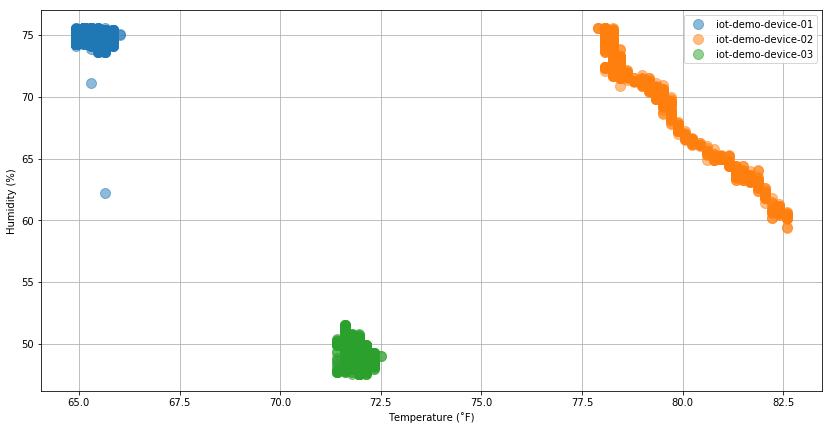

In [12]:
_, ax = plt.subplots(1, 1, figsize=(14,7))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for device, group in groups:
    ax.plot(group.temp, 
            group.humidity, 
            marker='o', 
            linestyle='', 
            alpha=.5,
            ms=10, 
            label=device)
ax.grid()
ax.legend()
plt.xlabel("Temperature (˚F)")
plt.ylabel("Humidity (%)")
plt.show()

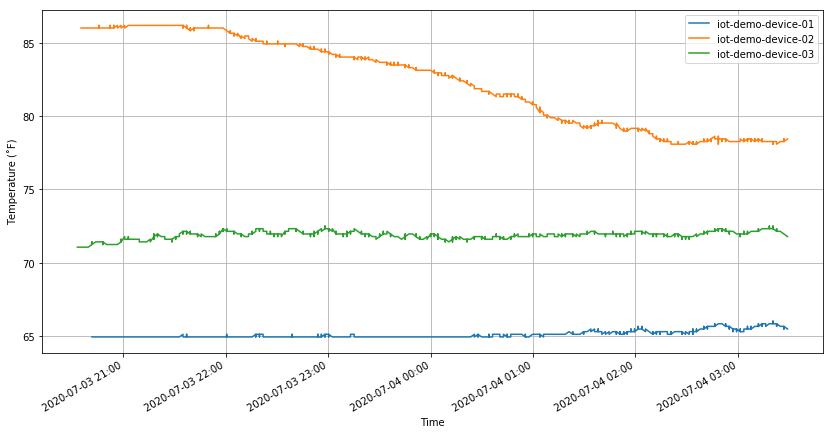

In [8]:
register_matplotlib_converters()
fig, ax = plt.subplots(1, 1, figsize=(14,7))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for device, group in groups:
    ax.plot(group.temp,
            label=device)
myFmt = DateFormatter("%Y-%m-%d %H:%M")
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
ax.grid()
ax.legend()
plt.ylabel("Temperature (˚F)")
plt.xlabel("Time")
plt.show()